##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.9.1


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   57344/84125825 [..............................] - ETA: 2:19

  122880/84125825 [..............................] - ETA: 2:09

  221184/84125825 [..............................] - ETA: 1:48

  352256/84125825 [..............................] - ETA: 1:30

  532480/84125825 [..............................] - ETA: 1:14

  778240/84125825 [..............................] - ETA: 1:00

 1105920/84125825 [..............................] - ETA: 49s 

 1335296/84125825 [..............................] - ETA: 44s

 1777664/84125825 [..............................] - ETA: 35s

 2220032/84125825 [..............................] - ETA: 31s

 2646016/84125825 [..............................] - ETA: 27s

 3334144/84125825 [>.............................] - ETA: 23s

 4161536/84125825 [>.............................] - ETA: 19s

 5087232/84125825 [>.............................] - ETA: 16s

 6037504/84125825 [=>............................] - ETA: 14s

 7372800/84125825 [=>............................] - ETA: 12s

 9003008/84125825 [==>...........................] - ETA: 10s

10887168/84125825 [==>...........................] - ETA: 8s 

13090816/84125825 [===>..........................] - ETA: 7s

15605760/84125825 [====>.........................] - ETA: 6s

18538496/84125825 [=====>........................] - ETA: 5s

21618688/84125825 [======>.......................] - ETA: 4s

24682496/84125825 [=======>......................] - ETA: 3s

27975680/84125825 [========>.....................] - ETA: 3s

31252480/84125825 [==========>...................] - ETA: 2s

34201600/84125825 [===========>..................] - ETA: 2s

37494784/84125825 [============>.................] - ETA: 2s

40525824/84125825 [=============>................] - ETA: 1s

43802624/84125825 [==============>...............] - ETA: 1s

46964736/84125825 [===============>..............] - ETA: 1s

50012160/84125825 [================>.............] - ETA: 1s

53321728/84125825 [==================>...........] - ETA: 1s

56614912/84125825 [===================>..........] - ETA: 0s

59908096/84125825 [====================>.........] - ETA: 0s

63176704/84125825 [=====================>........] - ETA: 0s

66199552/84125825 [======================>.......] - ETA: 0s

69476352/84125825 [=======================>......] - ETA: 0s

72589312/84125825 [========================>.....] - ETA: 0s

75735040/84125825 [==========================>...] - ETA: 0s

79028224/84125825 [===========================>..] - ETA: 0s

82042880/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 2s 0us/step


In [6]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'imdbEr.txt', 'train', 'test']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'pos',
 'labeledBow.feat',
 'neg',
 'unsup',
 'urls_unsup.txt',
 'urls_neg.txt',
 'urls_pos.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (G  (None, 16)               0         


 lobalAveragePooling1D)                                          


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160,033


Trainable params: 160,033


Non-trainable params: 0


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 21:36 - loss: 0.6934 - binary_accuracy: 0.4375

 15/625 [..............................] - ETA: 2s - loss: 0.6929 - binary_accuracy: 0.5521   

 30/625 [>.............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5594

 45/625 [=>............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5417

 60/625 [=>............................] - ETA: 2s - loss: 0.6923 - binary_accuracy: 0.5479

 75/625 [==>...........................] - ETA: 1s - loss: 0.6920 - binary_accuracy: 0.5421

 90/625 [===>..........................] - ETA: 1s - loss: 0.6918 - binary_accuracy: 0.5354

105/625 [====>.........................] - ETA: 1s - loss: 0.6917 - binary_accuracy: 0.5271

120/625 [====>.........................] - ETA: 1s - loss: 0.6915 - binary_accuracy: 0.5349

135/625 [=====>........................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5544

150/625 [======>.......................] - ETA: 1s - loss: 0.6908 - binary_accuracy: 0.5688

165/625 [======>.......................] - ETA: 1s - loss: 0.6905 - binary_accuracy: 0.5784

181/625 [=======>......................] - ETA: 1s - loss: 0.6900 - binary_accuracy: 0.5860

197/625 [========>.....................] - ETA: 1s - loss: 0.6897 - binary_accuracy: 0.5852

213/625 [=========>....................] - ETA: 1s - loss: 0.6893 - binary_accuracy: 0.5882

228/625 [=========>....................] - ETA: 1s - loss: 0.6887 - binary_accuracy: 0.5979

243/625 [==========>...................] - ETA: 1s - loss: 0.6881 - binary_accuracy: 0.6066

258/625 [===========>..................] - ETA: 1s - loss: 0.6875 - binary_accuracy: 0.6147

273/625 [============>.................] - ETA: 1s - loss: 0.6869 - binary_accuracy: 0.6211

288/625 [============>.................] - ETA: 1s - loss: 0.6863 - binary_accuracy: 0.6259

303/625 [=============>................] - ETA: 1s - loss: 0.6857 - binary_accuracy: 0.6308

318/625 [==============>...............] - ETA: 1s - loss: 0.6850 - binary_accuracy: 0.6331

333/625 [==============>...............] - ETA: 1s - loss: 0.6843 - binary_accuracy: 0.6367

348/625 [===============>..............] - ETA: 0s - loss: 0.6837 - binary_accuracy: 0.6396

363/625 [================>.............] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.6425

378/625 [=================>............] - ETA: 0s - loss: 0.6821 - binary_accuracy: 0.6473

393/625 [=================>............] - ETA: 0s - loss: 0.6811 - binary_accuracy: 0.6531

408/625 [==================>...........] - ETA: 0s - loss: 0.6802 - binary_accuracy: 0.6566

423/625 [===================>..........] - ETA: 0s - loss: 0.6792 - binary_accuracy: 0.6608

438/625 [====================>.........] - ETA: 0s - loss: 0.6783 - binary_accuracy: 0.6640

453/625 [====================>.........] - ETA: 0s - loss: 0.6772 - binary_accuracy: 0.6672

468/625 [=====================>........] - ETA: 0s - loss: 0.6763 - binary_accuracy: 0.6702

483/625 [======================>.......] - ETA: 0s - loss: 0.6753 - binary_accuracy: 0.6716

498/625 [======================>.......] - ETA: 0s - loss: 0.6742 - binary_accuracy: 0.6745

513/625 [=======================>......] - ETA: 0s - loss: 0.6731 - binary_accuracy: 0.6768

528/625 [========================>.....] - ETA: 0s - loss: 0.6720 - binary_accuracy: 0.6792

543/625 [=========================>....] - ETA: 0s - loss: 0.6710 - binary_accuracy: 0.6816

558/625 [=========================>....] - ETA: 0s - loss: 0.6698 - binary_accuracy: 0.6840

573/625 [==========================>...] - ETA: 0s - loss: 0.6687 - binary_accuracy: 0.6861

588/625 [===========================>..] - ETA: 0s - loss: 0.6677 - binary_accuracy: 0.6878

603/625 [===========================>..] - ETA: 0s - loss: 0.6662 - binary_accuracy: 0.6905

618/625 [============================>.] - ETA: 0s - loss: 0.6652 - binary_accuracy: 0.6921

625/625 [==============================] - 5s 4ms/step - loss: 0.6646 - binary_accuracy: 0.6932 - val_loss: 0.6148 - val_binary_accuracy: 0.7702


Epoch 2/10


  1/625 [..............................] - ETA: 2s - loss: 0.5821 - binary_accuracy: 0.8438

 17/625 [..............................] - ETA: 2s - loss: 0.6096 - binary_accuracy: 0.7794

 33/625 [>.............................] - ETA: 1s - loss: 0.6081 - binary_accuracy: 0.7756

 49/625 [=>............................] - ETA: 1s - loss: 0.6054 - binary_accuracy: 0.7730

 64/625 [==>...........................] - ETA: 1s - loss: 0.6033 - binary_accuracy: 0.7734

 80/625 [==>...........................] - ETA: 1s - loss: 0.6021 - binary_accuracy: 0.7727

 96/625 [===>..........................] - ETA: 1s - loss: 0.6018 - binary_accuracy: 0.7695

112/625 [====>.........................] - ETA: 1s - loss: 0.5992 - binary_accuracy: 0.7732

128/625 [=====>........................] - ETA: 1s - loss: 0.5979 - binary_accuracy: 0.7732

144/625 [=====>........................] - ETA: 1s - loss: 0.5962 - binary_accuracy: 0.7752

160/625 [======>.......................] - ETA: 1s - loss: 0.5958 - binary_accuracy: 0.7738

176/625 [=======>......................] - ETA: 1s - loss: 0.5935 - binary_accuracy: 0.7759

192/625 [========>.....................] - ETA: 1s - loss: 0.5918 - binary_accuracy: 0.7770

208/625 [========>.....................] - ETA: 1s - loss: 0.5909 - binary_accuracy: 0.7766

224/625 [=========>....................] - ETA: 1s - loss: 0.5885 - binary_accuracy: 0.7771

240/625 [==========>...................] - ETA: 1s - loss: 0.5864 - binary_accuracy: 0.7789

256/625 [===========>..................] - ETA: 1s - loss: 0.5844 - binary_accuracy: 0.7803

272/625 [============>.................] - ETA: 1s - loss: 0.5820 - binary_accuracy: 0.7823

288/625 [============>.................] - ETA: 1s - loss: 0.5805 - binary_accuracy: 0.7828

304/625 [=============>................] - ETA: 1s - loss: 0.5792 - binary_accuracy: 0.7824

320/625 [==============>...............] - ETA: 0s - loss: 0.5782 - binary_accuracy: 0.7815

336/625 [===============>..............] - ETA: 0s - loss: 0.5767 - binary_accuracy: 0.7826

352/625 [===============>..............] - ETA: 0s - loss: 0.5753 - binary_accuracy: 0.7836

367/625 [================>.............] - ETA: 0s - loss: 0.5735 - binary_accuracy: 0.7853

383/625 [=================>............] - ETA: 0s - loss: 0.5716 - binary_accuracy: 0.7868

399/625 [==================>...........] - ETA: 0s - loss: 0.5695 - binary_accuracy: 0.7883

415/625 [==================>...........] - ETA: 0s - loss: 0.5675 - binary_accuracy: 0.7893

431/625 [===================>..........] - ETA: 0s - loss: 0.5655 - binary_accuracy: 0.7907

447/625 [====================>.........] - ETA: 0s - loss: 0.5642 - binary_accuracy: 0.7915

462/625 [=====================>........] - ETA: 0s - loss: 0.5627 - binary_accuracy: 0.7927

478/625 [=====================>........] - ETA: 0s - loss: 0.5615 - binary_accuracy: 0.7930

494/625 [======================>.......] - ETA: 0s - loss: 0.5594 - binary_accuracy: 0.7943

509/625 [=======================>......] - ETA: 0s - loss: 0.5578 - binary_accuracy: 0.7955

524/625 [========================>.....] - ETA: 0s - loss: 0.5565 - binary_accuracy: 0.7960

540/625 [========================>.....] - ETA: 0s - loss: 0.5551 - binary_accuracy: 0.7967

555/625 [=========================>....] - ETA: 0s - loss: 0.5538 - binary_accuracy: 0.7972

570/625 [==========================>...] - ETA: 0s - loss: 0.5523 - binary_accuracy: 0.7980

586/625 [===========================>..] - ETA: 0s - loss: 0.5512 - binary_accuracy: 0.7981

602/625 [===========================>..] - ETA: 0s - loss: 0.5494 - binary_accuracy: 0.7992

617/625 [============================>.] - ETA: 0s - loss: 0.5485 - binary_accuracy: 0.7992

625/625 [==============================] - 2s 4ms/step - loss: 0.5477 - binary_accuracy: 0.7997 - val_loss: 0.4971 - val_binary_accuracy: 0.8222


Epoch 3/10


  1/625 [..............................] - ETA: 2s - loss: 0.4376 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 2s - loss: 0.4821 - binary_accuracy: 0.8290

 33/625 [>.............................] - ETA: 1s - loss: 0.4814 - binary_accuracy: 0.8248

 49/625 [=>............................] - ETA: 1s - loss: 0.4802 - binary_accuracy: 0.8265

 64/625 [==>...........................] - ETA: 1s - loss: 0.4788 - binary_accuracy: 0.8276

 79/625 [==>...........................] - ETA: 1s - loss: 0.4794 - binary_accuracy: 0.8248

 95/625 [===>..........................] - ETA: 1s - loss: 0.4793 - binary_accuracy: 0.8253

110/625 [====>.........................] - ETA: 1s - loss: 0.4766 - binary_accuracy: 0.8284

126/625 [=====>........................] - ETA: 1s - loss: 0.4767 - binary_accuracy: 0.8274

142/625 [=====>........................] - ETA: 1s - loss: 0.4756 - binary_accuracy: 0.8277

158/625 [======>.......................] - ETA: 1s - loss: 0.4767 - binary_accuracy: 0.8263

174/625 [=======>......................] - ETA: 1s - loss: 0.4747 - binary_accuracy: 0.8283

190/625 [========>.....................] - ETA: 1s - loss: 0.4732 - binary_accuracy: 0.8299

205/625 [========>.....................] - ETA: 1s - loss: 0.4738 - binary_accuracy: 0.8291

220/625 [=========>....................] - ETA: 1s - loss: 0.4715 - binary_accuracy: 0.8305

236/625 [==========>...................] - ETA: 1s - loss: 0.4707 - binary_accuracy: 0.8308

252/625 [===========>..................] - ETA: 1s - loss: 0.4678 - binary_accuracy: 0.8325

268/625 [===========>..................] - ETA: 1s - loss: 0.4662 - binary_accuracy: 0.8336

283/625 [============>.................] - ETA: 1s - loss: 0.4648 - binary_accuracy: 0.8349

298/625 [=============>................] - ETA: 1s - loss: 0.4653 - binary_accuracy: 0.8340

314/625 [==============>...............] - ETA: 1s - loss: 0.4645 - binary_accuracy: 0.8340

330/625 [==============>...............] - ETA: 0s - loss: 0.4641 - binary_accuracy: 0.8343

346/625 [===============>..............] - ETA: 0s - loss: 0.4631 - binary_accuracy: 0.8343

362/625 [================>.............] - ETA: 0s - loss: 0.4617 - binary_accuracy: 0.8356

377/625 [=================>............] - ETA: 0s - loss: 0.4605 - binary_accuracy: 0.8365

392/625 [=================>............] - ETA: 0s - loss: 0.4586 - binary_accuracy: 0.8377

408/625 [==================>...........] - ETA: 0s - loss: 0.4568 - binary_accuracy: 0.8388

424/625 [===================>..........] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8393

440/625 [====================>.........] - ETA: 0s - loss: 0.4539 - binary_accuracy: 0.8404

455/625 [====================>.........] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8407

471/625 [=====================>........] - ETA: 0s - loss: 0.4523 - binary_accuracy: 0.8418

487/625 [======================>.......] - ETA: 0s - loss: 0.4513 - binary_accuracy: 0.8416

503/625 [=======================>......] - ETA: 0s - loss: 0.4498 - binary_accuracy: 0.8426

518/625 [=======================>......] - ETA: 0s - loss: 0.4486 - binary_accuracy: 0.8433

534/625 [========================>.....] - ETA: 0s - loss: 0.4476 - binary_accuracy: 0.8436

550/625 [=========================>....] - ETA: 0s - loss: 0.4467 - binary_accuracy: 0.8441

566/625 [==========================>...] - ETA: 0s - loss: 0.4459 - binary_accuracy: 0.8448

582/625 [==========================>...] - ETA: 0s - loss: 0.4453 - binary_accuracy: 0.8448

598/625 [===========================>..] - ETA: 0s - loss: 0.4443 - binary_accuracy: 0.8454

614/625 [============================>.] - ETA: 0s - loss: 0.4437 - binary_accuracy: 0.8451

625/625 [==============================] - 2s 4ms/step - loss: 0.4432 - binary_accuracy: 0.8449 - val_loss: 0.4190 - val_binary_accuracy: 0.8480


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3588 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.3931 - binary_accuracy: 0.8672

 32/625 [>.............................] - ETA: 1s - loss: 0.3980 - binary_accuracy: 0.8623

 47/625 [=>............................] - ETA: 1s - loss: 0.3989 - binary_accuracy: 0.8610

 62/625 [=>............................] - ETA: 1s - loss: 0.3983 - binary_accuracy: 0.8604

 78/625 [==>...........................] - ETA: 1s - loss: 0.4012 - binary_accuracy: 0.8554

 94/625 [===>..........................] - ETA: 1s - loss: 0.3997 - binary_accuracy: 0.8584

109/625 [====>.........................] - ETA: 1s - loss: 0.3978 - binary_accuracy: 0.8598

124/625 [====>.........................] - ETA: 1s - loss: 0.3972 - binary_accuracy: 0.8591

140/625 [=====>........................] - ETA: 1s - loss: 0.3971 - binary_accuracy: 0.8587

156/625 [======>.......................] - ETA: 1s - loss: 0.3987 - binary_accuracy: 0.8574

172/625 [=======>......................] - ETA: 1s - loss: 0.3965 - binary_accuracy: 0.8596

188/625 [========>.....................] - ETA: 1s - loss: 0.3958 - binary_accuracy: 0.8587

203/625 [========>.....................] - ETA: 1s - loss: 0.3967 - binary_accuracy: 0.8579

219/625 [=========>....................] - ETA: 1s - loss: 0.3949 - binary_accuracy: 0.8603

235/625 [==========>...................] - ETA: 1s - loss: 0.3954 - binary_accuracy: 0.8588

251/625 [===========>..................] - ETA: 1s - loss: 0.3925 - binary_accuracy: 0.8598

267/625 [===========>..................] - ETA: 1s - loss: 0.3912 - binary_accuracy: 0.8622

283/625 [============>.................] - ETA: 1s - loss: 0.3902 - binary_accuracy: 0.8623

299/625 [=============>................] - ETA: 1s - loss: 0.3914 - binary_accuracy: 0.8606

315/625 [==============>...............] - ETA: 1s - loss: 0.3917 - binary_accuracy: 0.8597

331/625 [==============>...............] - ETA: 0s - loss: 0.3914 - binary_accuracy: 0.8592

346/625 [===============>..............] - ETA: 0s - loss: 0.3906 - binary_accuracy: 0.8593

362/625 [================>.............] - ETA: 0s - loss: 0.3895 - binary_accuracy: 0.8604

378/625 [=================>............] - ETA: 0s - loss: 0.3885 - binary_accuracy: 0.8609

394/625 [=================>............] - ETA: 0s - loss: 0.3865 - binary_accuracy: 0.8620

409/625 [==================>...........] - ETA: 0s - loss: 0.3855 - binary_accuracy: 0.8628

424/625 [===================>..........] - ETA: 0s - loss: 0.3847 - binary_accuracy: 0.8630

440/625 [====================>.........] - ETA: 0s - loss: 0.3834 - binary_accuracy: 0.8635

456/625 [====================>.........] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.8640

472/625 [=====================>........] - ETA: 0s - loss: 0.3823 - binary_accuracy: 0.8643

488/625 [======================>.......] - ETA: 0s - loss: 0.3815 - binary_accuracy: 0.8651

504/625 [=======================>......] - ETA: 0s - loss: 0.3804 - binary_accuracy: 0.8658

520/625 [=======================>......] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8660

536/625 [========================>.....] - ETA: 0s - loss: 0.3795 - binary_accuracy: 0.8656

552/625 [=========================>....] - ETA: 0s - loss: 0.3790 - binary_accuracy: 0.8657

568/625 [==========================>...] - ETA: 0s - loss: 0.3783 - binary_accuracy: 0.8656

584/625 [===========================>..] - ETA: 0s - loss: 0.3784 - binary_accuracy: 0.8654

599/625 [===========================>..] - ETA: 0s - loss: 0.3782 - binary_accuracy: 0.8654

615/625 [============================>.] - ETA: 0s - loss: 0.3778 - binary_accuracy: 0.8657

625/625 [==============================] - 2s 4ms/step - loss: 0.3775 - binary_accuracy: 0.8655 - val_loss: 0.3730 - val_binary_accuracy: 0.8608


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3405 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.3415 - binary_accuracy: 0.8848

 31/625 [>.............................] - ETA: 1s - loss: 0.3444 - binary_accuracy: 0.8790

 46/625 [=>............................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8764

 62/625 [=>............................] - ETA: 1s - loss: 0.3471 - binary_accuracy: 0.8765

 78/625 [==>...........................] - ETA: 1s - loss: 0.3512 - binary_accuracy: 0.8726

 94/625 [===>..........................] - ETA: 1s - loss: 0.3499 - binary_accuracy: 0.8730

110/625 [====>.........................] - ETA: 1s - loss: 0.3482 - binary_accuracy: 0.8733

126/625 [=====>........................] - ETA: 1s - loss: 0.3476 - binary_accuracy: 0.8733

142/625 [=====>........................] - ETA: 1s - loss: 0.3461 - binary_accuracy: 0.8728

158/625 [======>.......................] - ETA: 1s - loss: 0.3496 - binary_accuracy: 0.8712

174/625 [=======>......................] - ETA: 1s - loss: 0.3476 - binary_accuracy: 0.8734

190/625 [========>.....................] - ETA: 1s - loss: 0.3468 - binary_accuracy: 0.8725

206/625 [========>.....................] - ETA: 1s - loss: 0.3484 - binary_accuracy: 0.8720

222/625 [=========>....................] - ETA: 1s - loss: 0.3474 - binary_accuracy: 0.8726

238/625 [==========>...................] - ETA: 1s - loss: 0.3475 - binary_accuracy: 0.8716

254/625 [===========>..................] - ETA: 1s - loss: 0.3461 - binary_accuracy: 0.8725

270/625 [===========>..................] - ETA: 1s - loss: 0.3438 - binary_accuracy: 0.8756

286/625 [============>.................] - ETA: 1s - loss: 0.3452 - binary_accuracy: 0.8743

302/625 [=============>................] - ETA: 1s - loss: 0.3461 - binary_accuracy: 0.8727

318/625 [==============>...............] - ETA: 1s - loss: 0.3459 - binary_accuracy: 0.8728

334/625 [===============>..............] - ETA: 0s - loss: 0.3454 - binary_accuracy: 0.8730

350/625 [===============>..............] - ETA: 0s - loss: 0.3448 - binary_accuracy: 0.8729

366/625 [================>.............] - ETA: 0s - loss: 0.3433 - binary_accuracy: 0.8740

382/625 [=================>............] - ETA: 0s - loss: 0.3427 - binary_accuracy: 0.8742

398/625 [==================>...........] - ETA: 0s - loss: 0.3417 - binary_accuracy: 0.8748

414/625 [==================>...........] - ETA: 0s - loss: 0.3407 - binary_accuracy: 0.8759

430/625 [===================>..........] - ETA: 0s - loss: 0.3394 - binary_accuracy: 0.8765

446/625 [====================>.........] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8770

462/625 [=====================>........] - ETA: 0s - loss: 0.3384 - binary_accuracy: 0.8769

477/625 [=====================>........] - ETA: 0s - loss: 0.3387 - binary_accuracy: 0.8767

493/625 [======================>.......] - ETA: 0s - loss: 0.3371 - binary_accuracy: 0.8777

509/625 [=======================>......] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8782

525/625 [========================>.....] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8782

541/625 [========================>.....] - ETA: 0s - loss: 0.3363 - binary_accuracy: 0.8779

557/625 [=========================>....] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.8784

573/625 [==========================>...] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8784

589/625 [===========================>..] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8778

605/625 [============================>.] - ETA: 0s - loss: 0.3360 - binary_accuracy: 0.8781

621/625 [============================>.] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8777

625/625 [==============================] - 2s 4ms/step - loss: 0.3358 - binary_accuracy: 0.8778 - val_loss: 0.3446 - val_binary_accuracy: 0.8672


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.2975 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.3037 - binary_accuracy: 0.9082

 32/625 [>.............................] - ETA: 1s - loss: 0.3076 - binary_accuracy: 0.8984

 48/625 [=>............................] - ETA: 1s - loss: 0.3090 - binary_accuracy: 0.8932

 64/625 [==>...........................] - ETA: 1s - loss: 0.3082 - binary_accuracy: 0.8896

 80/625 [==>...........................] - ETA: 1s - loss: 0.3128 - binary_accuracy: 0.8836

 96/625 [===>..........................] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8848

112/625 [====>.........................] - ETA: 1s - loss: 0.3128 - binary_accuracy: 0.8842

128/625 [=====>........................] - ETA: 1s - loss: 0.3134 - binary_accuracy: 0.8838

144/625 [=====>........................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8830

160/625 [======>.......................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8824

176/625 [=======>......................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8846

192/625 [========>.....................] - ETA: 1s - loss: 0.3126 - binary_accuracy: 0.8841

208/625 [========>.....................] - ETA: 1s - loss: 0.3139 - binary_accuracy: 0.8845

224/625 [=========>....................] - ETA: 1s - loss: 0.3132 - binary_accuracy: 0.8846

240/625 [==========>...................] - ETA: 1s - loss: 0.3134 - binary_accuracy: 0.8840

256/625 [===========>..................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8849

272/625 [============>.................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8873

288/625 [============>.................] - ETA: 1s - loss: 0.3116 - binary_accuracy: 0.8862

304/625 [=============>................] - ETA: 1s - loss: 0.3120 - binary_accuracy: 0.8850

320/625 [==============>...............] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.8850

336/625 [===============>..............] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8848

352/625 [===============>..............] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8847

368/625 [================>.............] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8849

384/625 [=================>............] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8853

400/625 [==================>...........] - ETA: 0s - loss: 0.3088 - binary_accuracy: 0.8858

415/625 [==================>...........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8866

431/625 [===================>..........] - ETA: 0s - loss: 0.3066 - binary_accuracy: 0.8873

447/625 [====================>.........] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.8872

463/625 [=====================>........] - ETA: 0s - loss: 0.3056 - binary_accuracy: 0.8876

478/625 [=====================>........] - ETA: 0s - loss: 0.3064 - binary_accuracy: 0.8874

494/625 [======================>.......] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8881

510/625 [=======================>......] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8884

526/625 [========================>.....] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8884

542/625 [=========================>....] - ETA: 0s - loss: 0.3040 - binary_accuracy: 0.8879

558/625 [=========================>....] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8886

574/625 [==========================>...] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8887

590/625 [===========================>..] - ETA: 0s - loss: 0.3045 - binary_accuracy: 0.8883

606/625 [============================>.] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8883

622/625 [============================>.] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8882

625/625 [==============================] - 2s 4ms/step - loss: 0.3043 - binary_accuracy: 0.8882 - val_loss: 0.3256 - val_binary_accuracy: 0.8704


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.3003 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2826 - binary_accuracy: 0.9118

 33/625 [>.............................] - ETA: 1s - loss: 0.2812 - binary_accuracy: 0.9062

 49/625 [=>............................] - ETA: 1s - loss: 0.2825 - binary_accuracy: 0.9005

 65/625 [==>...........................] - ETA: 1s - loss: 0.2832 - binary_accuracy: 0.8995

 81/625 [==>...........................] - ETA: 1s - loss: 0.2862 - binary_accuracy: 0.8970

 96/625 [===>..........................] - ETA: 1s - loss: 0.2886 - binary_accuracy: 0.8958

111/625 [====>.........................] - ETA: 1s - loss: 0.2877 - binary_accuracy: 0.8964

126/625 [=====>........................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8971

141/625 [=====>........................] - ETA: 1s - loss: 0.2854 - binary_accuracy: 0.8943

156/625 [======>.......................] - ETA: 1s - loss: 0.2896 - binary_accuracy: 0.8920

171/625 [=======>......................] - ETA: 1s - loss: 0.2880 - binary_accuracy: 0.8931

187/625 [=======>......................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8939

203/625 [========>.....................] - ETA: 1s - loss: 0.2882 - binary_accuracy: 0.8930

219/625 [=========>....................] - ETA: 1s - loss: 0.2871 - binary_accuracy: 0.8937

234/625 [==========>...................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8925

249/625 [==========>...................] - ETA: 1s - loss: 0.2879 - binary_accuracy: 0.8924

264/625 [===========>..................] - ETA: 1s - loss: 0.2872 - binary_accuracy: 0.8941

279/625 [============>.................] - ETA: 1s - loss: 0.2858 - binary_accuracy: 0.8954

295/625 [=============>................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8934

310/625 [=============>................] - ETA: 1s - loss: 0.2891 - binary_accuracy: 0.8936

326/625 [==============>...............] - ETA: 0s - loss: 0.2888 - binary_accuracy: 0.8933

341/625 [===============>..............] - ETA: 0s - loss: 0.2880 - binary_accuracy: 0.8933

356/625 [================>.............] - ETA: 0s - loss: 0.2878 - binary_accuracy: 0.8929

371/625 [================>.............] - ETA: 0s - loss: 0.2864 - binary_accuracy: 0.8936

387/625 [=================>............] - ETA: 0s - loss: 0.2861 - binary_accuracy: 0.8940

402/625 [==================>...........] - ETA: 0s - loss: 0.2849 - binary_accuracy: 0.8946

418/625 [===================>..........] - ETA: 0s - loss: 0.2841 - binary_accuracy: 0.8952

433/625 [===================>..........] - ETA: 0s - loss: 0.2832 - binary_accuracy: 0.8955

448/625 [====================>.........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8954

464/625 [=====================>........] - ETA: 0s - loss: 0.2825 - binary_accuracy: 0.8954

480/625 [======================>.......] - ETA: 0s - loss: 0.2830 - binary_accuracy: 0.8956

496/625 [======================>.......] - ETA: 0s - loss: 0.2817 - binary_accuracy: 0.8964

512/625 [=======================>......] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8966

528/625 [========================>.....] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8964

543/625 [=========================>....] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.8960

558/625 [=========================>....] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8965

573/625 [==========================>...] - ETA: 0s - loss: 0.2802 - binary_accuracy: 0.8968

589/625 [===========================>..] - ETA: 0s - loss: 0.2814 - binary_accuracy: 0.8961

605/625 [============================>.] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8961

621/625 [============================>.] - ETA: 0s - loss: 0.2818 - binary_accuracy: 0.8958

625/625 [==============================] - 2s 4ms/step - loss: 0.2815 - binary_accuracy: 0.8960 - val_loss: 0.3125 - val_binary_accuracy: 0.8732


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2478 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.2594 - binary_accuracy: 0.9219

 31/625 [>.............................] - ETA: 2s - loss: 0.2591 - binary_accuracy: 0.9143

 46/625 [=>............................] - ETA: 1s - loss: 0.2629 - binary_accuracy: 0.9090

 61/625 [=>............................] - ETA: 1s - loss: 0.2635 - binary_accuracy: 0.9083

 76/625 [==>...........................] - ETA: 1s - loss: 0.2692 - binary_accuracy: 0.9042

 91/625 [===>..........................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9045

107/625 [====>.........................] - ETA: 1s - loss: 0.2695 - binary_accuracy: 0.9045

122/625 [====>.........................] - ETA: 1s - loss: 0.2692 - binary_accuracy: 0.9052

138/625 [=====>........................] - ETA: 1s - loss: 0.2675 - binary_accuracy: 0.9033

154/625 [======>.......................] - ETA: 1s - loss: 0.2698 - binary_accuracy: 0.9012

169/625 [=======>......................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9018

185/625 [=======>......................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9022

200/625 [========>.....................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9013

215/625 [=========>....................] - ETA: 1s - loss: 0.2684 - binary_accuracy: 0.9022

230/625 [==========>...................] - ETA: 1s - loss: 0.2681 - binary_accuracy: 0.9020

246/625 [==========>...................] - ETA: 1s - loss: 0.2677 - binary_accuracy: 0.9017

261/625 [===========>..................] - ETA: 1s - loss: 0.2673 - binary_accuracy: 0.9025

276/625 [============>.................] - ETA: 1s - loss: 0.2655 - binary_accuracy: 0.9042

291/625 [============>.................] - ETA: 1s - loss: 0.2679 - binary_accuracy: 0.9032

306/625 [=============>................] - ETA: 1s - loss: 0.2682 - binary_accuracy: 0.9036

321/625 [==============>...............] - ETA: 1s - loss: 0.2682 - binary_accuracy: 0.9027

336/625 [===============>..............] - ETA: 0s - loss: 0.2674 - binary_accuracy: 0.9029

352/625 [===============>..............] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.9028

367/625 [================>.............] - ETA: 0s - loss: 0.2658 - binary_accuracy: 0.9032

382/625 [=================>............] - ETA: 0s - loss: 0.2654 - binary_accuracy: 0.9031

398/625 [==================>...........] - ETA: 0s - loss: 0.2647 - binary_accuracy: 0.9030

413/625 [==================>...........] - ETA: 0s - loss: 0.2640 - binary_accuracy: 0.9036

428/625 [===================>..........] - ETA: 0s - loss: 0.2630 - binary_accuracy: 0.9039

443/625 [====================>.........] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9040

458/625 [====================>.........] - ETA: 0s - loss: 0.2628 - binary_accuracy: 0.9039

473/625 [=====================>........] - ETA: 0s - loss: 0.2629 - binary_accuracy: 0.9038

488/625 [======================>.......] - ETA: 0s - loss: 0.2628 - binary_accuracy: 0.9035

503/625 [=======================>......] - ETA: 0s - loss: 0.2617 - binary_accuracy: 0.9041

519/625 [=======================>......] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9046

534/625 [========================>.....] - ETA: 0s - loss: 0.2614 - binary_accuracy: 0.9041

550/625 [=========================>....] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9043

565/625 [==========================>...] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9050

580/625 [==========================>...] - ETA: 0s - loss: 0.2620 - binary_accuracy: 0.9046

596/625 [===========================>..] - ETA: 0s - loss: 0.2623 - binary_accuracy: 0.9043

611/625 [============================>.] - ETA: 0s - loss: 0.2629 - binary_accuracy: 0.9039

625/625 [==============================] - 2s 4ms/step - loss: 0.2626 - binary_accuracy: 0.9042 - val_loss: 0.3036 - val_binary_accuracy: 0.8752


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2400 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.2443 - binary_accuracy: 0.9258

 31/625 [>.............................] - ETA: 2s - loss: 0.2423 - binary_accuracy: 0.9204

 46/625 [=>............................] - ETA: 2s - loss: 0.2438 - binary_accuracy: 0.9185

 61/625 [=>............................] - ETA: 1s - loss: 0.2459 - binary_accuracy: 0.9155

 76/625 [==>...........................] - ETA: 1s - loss: 0.2500 - binary_accuracy: 0.9124

 91/625 [===>..........................] - ETA: 1s - loss: 0.2492 - binary_accuracy: 0.9131

107/625 [====>.........................] - ETA: 1s - loss: 0.2511 - binary_accuracy: 0.9112

122/625 [====>.........................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9116

137/625 [=====>........................] - ETA: 1s - loss: 0.2490 - binary_accuracy: 0.9090

152/625 [======>.......................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9075

168/625 [=======>......................] - ETA: 1s - loss: 0.2501 - binary_accuracy: 0.9077

184/625 [=======>......................] - ETA: 1s - loss: 0.2478 - binary_accuracy: 0.9091

200/625 [========>.....................] - ETA: 1s - loss: 0.2496 - binary_accuracy: 0.9084

216/625 [=========>....................] - ETA: 1s - loss: 0.2496 - binary_accuracy: 0.9093

232/625 [==========>...................] - ETA: 1s - loss: 0.2502 - binary_accuracy: 0.9084

248/625 [==========>...................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9079

264/625 [===========>..................] - ETA: 1s - loss: 0.2490 - binary_accuracy: 0.9089

280/625 [============>.................] - ETA: 1s - loss: 0.2481 - binary_accuracy: 0.9099

296/625 [=============>................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9088

311/625 [=============>................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9092

326/625 [==============>...............] - ETA: 0s - loss: 0.2504 - binary_accuracy: 0.9089

341/625 [===============>..............] - ETA: 0s - loss: 0.2497 - binary_accuracy: 0.9088

357/625 [================>.............] - ETA: 0s - loss: 0.2491 - binary_accuracy: 0.9087

372/625 [================>.............] - ETA: 0s - loss: 0.2484 - binary_accuracy: 0.9093

388/625 [=================>............] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.9099

404/625 [==================>...........] - ETA: 0s - loss: 0.2469 - binary_accuracy: 0.9097

419/625 [===================>..........] - ETA: 0s - loss: 0.2461 - binary_accuracy: 0.9104

435/625 [===================>..........] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.9102

450/625 [====================>.........] - ETA: 0s - loss: 0.2453 - binary_accuracy: 0.9103

466/625 [=====================>........] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9111

482/625 [======================>.......] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9109

498/625 [======================>.......] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9113

514/625 [=======================>......] - ETA: 0s - loss: 0.2434 - binary_accuracy: 0.9120

530/625 [========================>.....] - ETA: 0s - loss: 0.2436 - binary_accuracy: 0.9117

546/625 [=========================>....] - ETA: 0s - loss: 0.2439 - binary_accuracy: 0.9116

562/625 [=========================>....] - ETA: 0s - loss: 0.2433 - binary_accuracy: 0.9121

577/625 [==========================>...] - ETA: 0s - loss: 0.2440 - binary_accuracy: 0.9118

593/625 [===========================>..] - ETA: 0s - loss: 0.2443 - binary_accuracy: 0.9116

609/625 [============================>.] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.9111

625/625 [==============================] - ETA: 0s - loss: 0.2450 - binary_accuracy: 0.9112

625/625 [==============================] - 2s 4ms/step - loss: 0.2450 - binary_accuracy: 0.9112 - val_loss: 0.2965 - val_binary_accuracy: 0.8786


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2159 - binary_accuracy: 0.9375

 16/625 [..............................] - ETA: 2s - loss: 0.2255 - binary_accuracy: 0.9336

 32/625 [>.............................] - ETA: 1s - loss: 0.2271 - binary_accuracy: 0.9238

 47/625 [=>............................] - ETA: 1s - loss: 0.2279 - binary_accuracy: 0.9222

 63/625 [==>...........................] - ETA: 1s - loss: 0.2286 - binary_accuracy: 0.9221

 79/625 [==>...........................] - ETA: 1s - loss: 0.2340 - binary_accuracy: 0.9161

 95/625 [===>..........................] - ETA: 1s - loss: 0.2349 - binary_accuracy: 0.9168

111/625 [====>.........................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9147

127/625 [=====>........................] - ETA: 1s - loss: 0.2366 - binary_accuracy: 0.9154

143/625 [=====>........................] - ETA: 1s - loss: 0.2353 - binary_accuracy: 0.9143

159/625 [======>.......................] - ETA: 1s - loss: 0.2381 - binary_accuracy: 0.9127

175/625 [=======>......................] - ETA: 1s - loss: 0.2351 - binary_accuracy: 0.9145

191/625 [========>.....................] - ETA: 1s - loss: 0.2353 - binary_accuracy: 0.9146

206/625 [========>.....................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9149

221/625 [=========>....................] - ETA: 1s - loss: 0.2356 - binary_accuracy: 0.9149

236/625 [==========>...................] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.9133

251/625 [===========>..................] - ETA: 1s - loss: 0.2353 - binary_accuracy: 0.9133

267/625 [===========>..................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9137

282/625 [============>.................] - ETA: 1s - loss: 0.2351 - binary_accuracy: 0.9145

297/625 [=============>................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9139

313/625 [==============>...............] - ETA: 1s - loss: 0.2372 - binary_accuracy: 0.9138

328/625 [==============>...............] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9142

343/625 [===============>..............] - ETA: 0s - loss: 0.2352 - binary_accuracy: 0.9142

358/625 [================>.............] - ETA: 0s - loss: 0.2348 - binary_accuracy: 0.9138

374/625 [================>.............] - ETA: 0s - loss: 0.2338 - binary_accuracy: 0.9142

389/625 [=================>............] - ETA: 0s - loss: 0.2332 - binary_accuracy: 0.9144

404/625 [==================>...........] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9150

419/625 [===================>..........] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9156

434/625 [===================>..........] - ETA: 0s - loss: 0.2311 - binary_accuracy: 0.9155

449/625 [====================>.........] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9156

464/625 [=====================>........] - ETA: 0s - loss: 0.2306 - binary_accuracy: 0.9155

479/625 [=====================>........] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9153

494/625 [======================>.......] - ETA: 0s - loss: 0.2304 - binary_accuracy: 0.9155

510/625 [=======================>......] - ETA: 0s - loss: 0.2291 - binary_accuracy: 0.9164

526/625 [========================>.....] - ETA: 0s - loss: 0.2293 - binary_accuracy: 0.9163

541/625 [========================>.....] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.9160

556/625 [=========================>....] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.9161

571/625 [==========================>...] - ETA: 0s - loss: 0.2296 - binary_accuracy: 0.9165

586/625 [===========================>..] - ETA: 0s - loss: 0.2309 - binary_accuracy: 0.9162

601/625 [===========================>..] - ETA: 0s - loss: 0.2315 - binary_accuracy: 0.9160

616/625 [============================>.] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9156

625/625 [==============================] - 2s 4ms/step - loss: 0.2317 - binary_accuracy: 0.9155 - val_loss: 0.2918 - val_binary_accuracy: 0.8788


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 45s - loss: 0.2975 - binary_accuracy: 0.8750

 25/782 [..............................] - ETA: 1s - loss: 0.3106 - binary_accuracy: 0.8888 

 50/782 [>.............................] - ETA: 1s - loss: 0.3171 - binary_accuracy: 0.8825

 75/782 [=>............................] - ETA: 1s - loss: 0.3230 - binary_accuracy: 0.8758

100/782 [==>...........................] - ETA: 1s - loss: 0.3206 - binary_accuracy: 0.8772

125/782 [===>..........................] - ETA: 1s - loss: 0.3130 - binary_accuracy: 0.8795

149/782 [====>.........................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8763

174/782 [=====>........................] - ETA: 1s - loss: 0.3098 - binary_accuracy: 0.8768

198/782 [======>.......................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8758

223/782 [=======>......................] - ETA: 1s - loss: 0.3122 - binary_accuracy: 0.8758

247/782 [========>.....................] - ETA: 1s - loss: 0.3100 - binary_accuracy: 0.8758

272/782 [=========>....................] - ETA: 1s - loss: 0.3106 - binary_accuracy: 0.8752

297/782 [==========>...................] - ETA: 1s - loss: 0.3103 - binary_accuracy: 0.8753

321/782 [===========>..................] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8749

346/782 [============>.................] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8752

371/782 [=============>................] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8747

396/782 [==============>...............] - ETA: 0s - loss: 0.3095 - binary_accuracy: 0.8743

421/782 [===============>..............] - ETA: 0s - loss: 0.3090 - binary_accuracy: 0.8740

446/782 [================>.............] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8740

471/782 [=================>............] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8729

496/782 [==================>...........] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.8723

521/782 [==================>...........] - ETA: 0s - loss: 0.3122 - binary_accuracy: 0.8724

546/782 [===================>..........] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8720

571/782 [====================>.........] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8718

595/782 [=====================>........] - ETA: 0s - loss: 0.3127 - binary_accuracy: 0.8714

619/782 [======================>.......] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.8716

644/782 [=======================>......] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.8717

669/782 [========================>.....] - ETA: 0s - loss: 0.3127 - binary_accuracy: 0.8714

694/782 [=========================>....] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.8718

719/782 [==========================>...] - ETA: 0s - loss: 0.3121 - binary_accuracy: 0.8719

744/782 [===========================>..] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8726

769/782 [============================>.] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8728

782/782 [==============================] - 2s 2ms/step - loss: 0.3105 - binary_accuracy: 0.8730


Loss:  0.31047186255455017
Accuracy:  0.8729599714279175


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

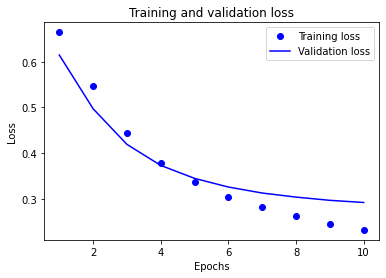

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

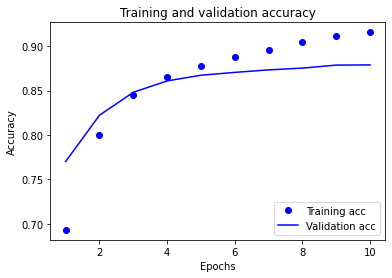

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 3:21 - loss: 0.2866 - accuracy: 0.9062

 14/782 [..............................] - ETA: 2s - loss: 0.3037 - accuracy: 0.8862  

 28/782 [>.............................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8862

 42/782 [>.............................] - ETA: 2s - loss: 0.3148 - accuracy: 0.8884

 56/782 [=>............................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8811

 70/782 [=>............................] - ETA: 2s - loss: 0.3155 - accuracy: 0.8813

 84/782 [==>...........................] - ETA: 2s - loss: 0.3189 - accuracy: 0.8795

 97/782 [==>...........................] - ETA: 2s - loss: 0.3214 - accuracy: 0.8776

111/782 [===>..........................] - ETA: 2s - loss: 0.3172 - accuracy: 0.8787

124/782 [===>..........................] - ETA: 2s - loss: 0.3149 - accuracy: 0.8778

138/782 [====>.........................] - ETA: 2s - loss: 0.3097 - accuracy: 0.8779

152/782 [====>.........................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8766

167/782 [=====>........................] - ETA: 2s - loss: 0.3129 - accuracy: 0.8750

181/782 [=====>........................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8750

195/782 [======>.......................] - ETA: 2s - loss: 0.3134 - accuracy: 0.8753

209/782 [=======>......................] - ETA: 2s - loss: 0.3117 - accuracy: 0.8772

223/782 [=======>......................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8760

237/782 [========>.....................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8745

251/782 [========>.....................] - ETA: 1s - loss: 0.3100 - accuracy: 0.8755

265/782 [=========>....................] - ETA: 1s - loss: 0.3097 - accuracy: 0.8757

279/782 [=========>....................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8743

293/782 [==========>...................] - ETA: 1s - loss: 0.3100 - accuracy: 0.8753

307/782 [==========>...................] - ETA: 1s - loss: 0.3096 - accuracy: 0.8751

321/782 [===========>..................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8738

335/782 [===========>..................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8739

349/782 [============>.................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8748

363/782 [============>.................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8744

377/782 [=============>................] - ETA: 1s - loss: 0.3108 - accuracy: 0.8741

392/782 [==============>...............] - ETA: 1s - loss: 0.3095 - accuracy: 0.8742

406/782 [==============>...............] - ETA: 1s - loss: 0.3095 - accuracy: 0.8745

420/782 [===============>..............] - ETA: 1s - loss: 0.3096 - accuracy: 0.8740

434/782 [===============>..............] - ETA: 1s - loss: 0.3088 - accuracy: 0.8744

448/782 [================>.............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8738

462/782 [================>.............] - ETA: 1s - loss: 0.3105 - accuracy: 0.8733

476/782 [=================>............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8728

490/782 [=================>............] - ETA: 1s - loss: 0.3115 - accuracy: 0.8724

504/782 [==================>...........] - ETA: 1s - loss: 0.3119 - accuracy: 0.8728

518/782 [==================>...........] - ETA: 0s - loss: 0.3119 - accuracy: 0.8726

532/782 [===================>..........] - ETA: 0s - loss: 0.3122 - accuracy: 0.8719

546/782 [===================>..........] - ETA: 0s - loss: 0.3115 - accuracy: 0.8722

560/782 [====================>.........] - ETA: 0s - loss: 0.3115 - accuracy: 0.8721

574/782 [=====================>........] - ETA: 0s - loss: 0.3111 - accuracy: 0.8717

588/782 [=====================>........] - ETA: 0s - loss: 0.3122 - accuracy: 0.8717

602/782 [======================>.......] - ETA: 0s - loss: 0.3126 - accuracy: 0.8714

616/782 [======================>.......] - ETA: 0s - loss: 0.3131 - accuracy: 0.8712

630/782 [=======================>......] - ETA: 0s - loss: 0.3130 - accuracy: 0.8716

644/782 [=======================>......] - ETA: 0s - loss: 0.3126 - accuracy: 0.8717

658/782 [========================>.....] - ETA: 0s - loss: 0.3128 - accuracy: 0.8717

672/782 [========================>.....] - ETA: 0s - loss: 0.3128 - accuracy: 0.8715

686/782 [=========================>....] - ETA: 0s - loss: 0.3126 - accuracy: 0.8719

700/782 [=========================>....] - ETA: 0s - loss: 0.3118 - accuracy: 0.8722

714/782 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8724

729/782 [==========================>...] - ETA: 0s - loss: 0.3111 - accuracy: 0.8724

743/782 [===========================>..] - ETA: 0s - loss: 0.3109 - accuracy: 0.8728

757/782 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8729

771/782 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8729

782/782 [==============================] - 3s 4ms/step - loss: 0.3105 - accuracy: 0.8730


0.8729599714279175


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 136ms/step


array([[0.6047846 ],
       [0.42489105],
       [0.3432073 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
